# AdaBoost + Bagging

In [1]:
import pandas as pd

In [2]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data', header = None) 

In [3]:
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

In [4]:
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values # .values puts into an array
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values


In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1,
                             stratify=y)

Actual Bagging

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [7]:
tree = DecisionTreeClassifier(
    criterion = 'entropy',
    random_state =1,
    max_depth = None)

In [8]:
bag = BaggingClassifier(
    estimator = tree,
    n_estimators = 500,
    max_samples = 1,
    max_features = 1,
    bootstrap = True,
    bootstrap_features = False,
    n_jobs =1,
    random_state =1)

In [9]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
      f'{tree_train:.3f}/{tree_test:.3f}')

Decision tree train/test accuracies 1.000/0.833


In [10]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 

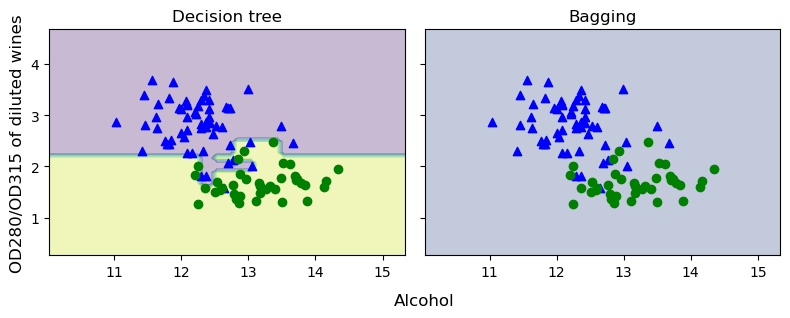

In [11]:
import numpy as np
import matplotlib.pyplot as plt


x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

plt.show()


# ADA weights from scratch

In [12]:
y = np.array([1, 1, 1, -1, -1, -1,  1,  1,  1, -1])
yhat = np.array([1, 1, 1, -1, -1, -1, -1, -1, -1, -1])

In [13]:
correct = (y == yhat)
weights = np.full(10, 0.1)
print(weights)

epsilon = np.mean(~correct) # proportion of incorrect preds
print(epsilon)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3


In [14]:
amount_of_say = 0.5*np.log((1-epsilon)/epsilon)
amount_of_say

0.42364893019360184

with the amount of say, we can now update the weights

In [15]:
correct_w_update = 0.1*np.exp(-amount_of_say*1*1)
correct_w_update

0.06546536707079771

In [16]:
wrong_w_update = 0.1*np.exp(-amount_of_say*1*-1)
wrong_w_update

0.1527525231651947

In [17]:
weights = np.where(correct == 1, correct_w_update,wrong_w_update)
weights

array([0.06546537, 0.06546537, 0.06546537, 0.06546537, 0.06546537,
       0.06546537, 0.15275252, 0.15275252, 0.15275252, 0.06546537])

Normalize the weights

In [18]:
normalized_w = weights/np.sum(weights)
normalized_w

array([0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.16666667, 0.16666667, 0.16666667, 0.07142857])

# ADABOOST with sklearn

In [19]:
from sklearn.ensemble import AdaBoostClassifier

In [22]:
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

In [23]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_test = accuracy_score(y_test, y_test_pred) 
ada_test

/opt/anaconda3/envs/islp/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.9166666666666666